In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
from scipy.spatial import distance
import math
from scipy import interpolate

In [3]:
#well info
wellcoord = np.loadtxt('df_wells_UTM.txt', delimiter=',', usecols=(1, 2, 3))
wells_x, wells_y, wells_z = wellcoord.T  # Transpose for easy unpacking

In [3]:
#functions
def euclidean_distance(x1, y1, x2, y2):
    """Calculate Euclidean distance between two points (x1, y1) and (x2, y2)"""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def angle_between_vectors(v1, v2):  
    v1 = np.array(v1)  
    v2 = np.array(v2)  
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))  
    angle = np.arccos(cos_theta)  # angle in radians  
    return np.degrees(angle)  # convert to degrees 

In [4]:
#translate direction to local system
angle_deg = 226 #North angle of transect direction
angle_rad = np.radians(angle_deg)

#create UTM vector 228
V_228 = (np.sin(angle_rad), np.cos(angle_rad))
V_opp = (-np.cos(angle_rad), np.sin(angle_rad))

In [5]:
#vector between well 1 and 2
V_12 = (x_coord[1] - x_coord[0], y_coord[1] - y_coord[0])

#anglewell12
angle_deg_1 = angle_between_vectors(V_228, V_12)
angle_deg_2 = angle_between_vectors(V_opp, V_12)
angle_rad_1, angle_rad_2 = np.radians(angle_deg_1), np.radians(angle_deg_2) #both angles in radians

dist_well12 = euclidean_distance(x_coord[0], y_coord[0], x_coord[1], y_coord[1])

#leg distance using sinus regel
b1 = (dist_well12 * np.sin(angle_rad_2)) / np.sin(np.radians(90))

In [6]:
#vector between well 1 and 2
V_32 = (x_coord[1] - x_coord[2], y_coord[1] - y_coord[2])

#anglewell12
angle_deg_3 = angle_between_vectors(V_228, V_32)
angle_deg_22 = angle_between_vectors(V_opp, V_32)
angle_rad_3, angle_rad_2 = np.radians(angle_deg_3), np.radians(angle_deg_22) #both angles in radians

dist_well32 = euclidean_distance(x_coord[2], y_coord[2], x_coord[1], y_coord[1])

#leg distance using sinus regel
b3 = (dist_well32 * np.sin(angle_rad_2)) / np.sin(np.radians(90))

In [7]:
print(b1, b3)

3.1133119659888844 3.11331204342382



[0, 3.1133119659888844, 6.2266240094127046, 9.198311965988884, 12.041311965988886, 14.885311965988885, 17.756311965988886, 20.558311965988885, 23.531311965988884, 26.363311965988885, 29.256311965988886, 33.21831196598888, 36.515311965988886, 39.552311965988885, 43.208311965988884, 47.421311965988885]

[ 0.    -0.261 -0.585 -0.852 -1.067 -1.342 -1.662 -1.932 -2.202 -2.452
 -2.692 -3.057 -3.377 -3.677 -4.017 -4.607]


(-2.3710655982994444, 49.79237756428833, -4.83735, 0.23035000000000003)

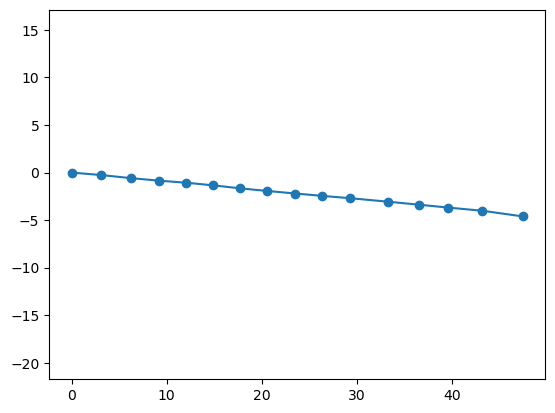

In [8]:
#This code is for altering the local transect and interpolate, so that it can be used as the iz input for matlab CoastalCam

#########known#########
laserheight = 0.015
#well base
distance_wells = [0, b1, b1+b3] #distance from well 1 (either 228, or 226 degree North)

#########input 04_10_24#########
#daily height fluctuations
fluc_wells = [value / 100 for value in [23.2, 19.4, 19.8]] #height well above sand level

transect_dist = [6.085, 8.928, 11.772, 14.643, 17.445, 20.418, 23.250, 26.143, 30.105, 33.402, 36.439, 40.095, 44.308] #distance from well 2
transect_z = [-0.77, -0.985, -1.26, -1.58, -1.85, -2.12, -2.37, -2.61, -2.975, -3.295, -3.595, -3.935, -4.525]

#########automatic part#########
#combine into one dist/z list
step1 = (transect_dist + distance_wells[1]) #distance from well 1
# Create new lists to store the combined data
dist = distance_wells.copy()  # Copy the original distance_wells list
dist.extend(step1)  # Add the calculated distances to the new dist list

# step2 = [z_well - fluc_well for z_well, fluc_well in zip(z_wells, fluc_wells)] #height correction for wells (list comprehension)
step3 = transect_z - (fluc_wells[1] + laserheight) * np.ones(len(transect_z))  # height correction for transect

step4 = z_wells - fluc_wells
step5 = step4 - step4[0]
step6 = (0 + step5[1] + fluc_wells[1] - laserheight) + transect_z

# Combine the height corrections into a single list
z = np.hstack((step5, step6))

# print(step2)
print()
print(dist)
print()
print(z)
# plot
plt.plot(dist, z, marker='o')
plt.ylim(-4, 0)
plt.xlim(0, 30)
plt.axis('equal')

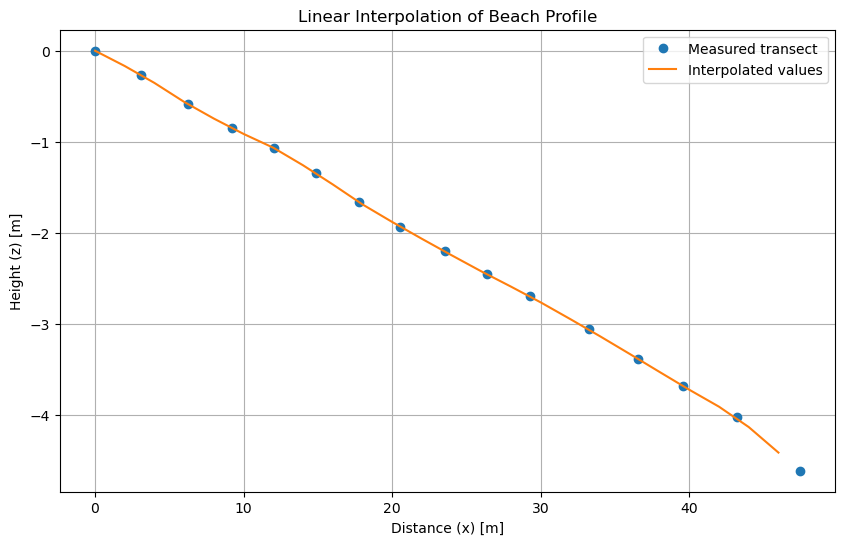

In [9]:
##interpolation
int_start = 0
int_end = 48 #look at last fitting point for interpolation
idxdy = 2 #matlab input

x_interp = np.arange(int_start, int_end, idxdy)
linear_interp = interpolate.interp1d(dist, z, kind='linear')
z_interp = linear_interp(x_interp)

# Plot the interpolated values
plt.figure(figsize=(10, 6))
plt.plot(dist, z, 'o', label='Measured transect')
plt.plot(x_interp, z_interp, '-', label='Interpolated values')
plt.xlabel('Distance (x) [m]')
plt.ylabel('Height (z) [m]')
plt.title('Linear Interpolation of Beach Profile')
plt.legend()
plt.grid(True)
plt.show()

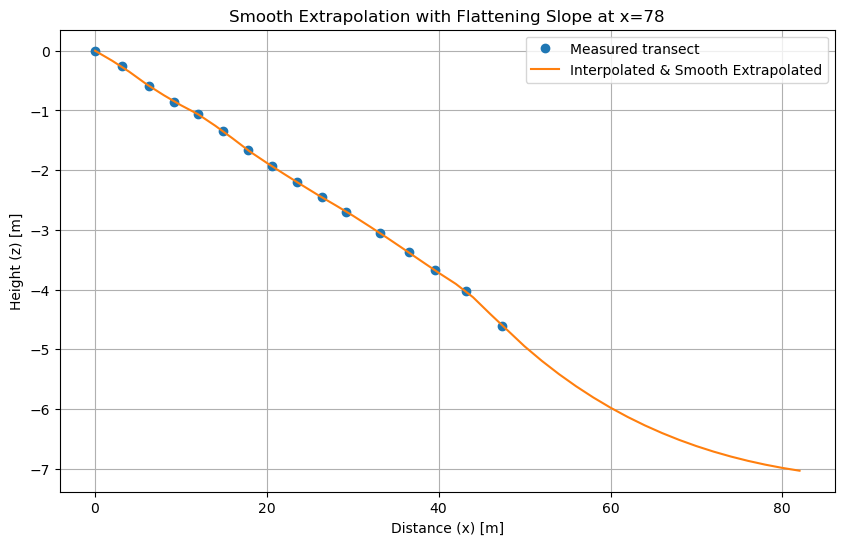

In [10]:
#extrapolation
ext_end = 80 + idxdy + 1
wherexis0 = 70
decay_rate = 0.02  # Controls how fast the slope decreases to 0


#####dont change anything below
ext_start = int_end + idxdy
x_extrap = np.arange(ext_start, ext_end, idxdy)

# Slope from the last two known points
slope_start = (z[-1] - z[-2]) / (dist[-1] - dist[-2])
z_start = z[-1]

# Smoothly decreasing slope to 0 using an exponential decay model
def smooth_extrapolation(x, x0, z0, slope, x_end, decay_rate):
    slope_factor = np.exp(-decay_rate * (x - x0))
    return z0 + slope * (x - x0) * slope_factor

# Parameters for smooth extrapolation

z_extrap = smooth_extrapolation(x_extrap, dist[-1], z_start, slope_start, wherexis0, decay_rate)

# Combine interpolated and extrapolated x and z values
x_total = np.concatenate([x_interp, x_extrap])
z_total = np.concatenate([z_interp, z_extrap])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dist, z, 'o', label='Measured transect')
plt.plot(x_total, z_total, '-', label='Interpolated & Smooth Extrapolated')
# plt.axvline(wherexis0, color='r', linestyle='--', label='Slope=0 at x=78')
plt.xlabel('Distance (x) [m]')
plt.ylabel('Height (z) [m]')
plt.title('Smooth Extrapolation with Flattening Slope at x=78')
plt.legend()
plt.grid(True)
plt.show()

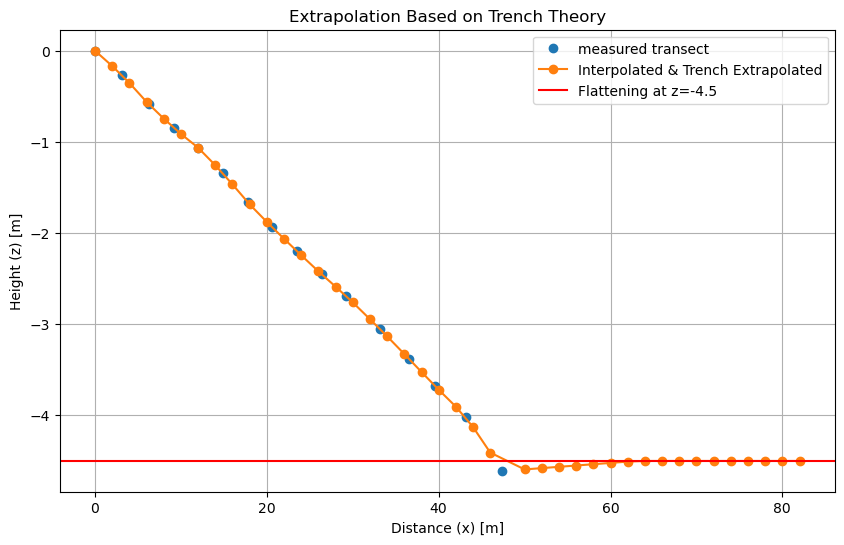

In [11]:
#extrapolation method 2
# Parameters for the new extrapolation
depth_point = z[-1]  # Last known depth
rise_height = -4.5  # Target flattening height
rise_distance = 15  # Distance over which to rise to the target height

# Compute the new extrapolation
def trench_extrapolation(x, depth_point, rise_height, rise_distance):
    # Linear rise from the last point to the rise height
    if x < (48 + rise_distance):
        return depth_point + (rise_height - depth_point) / rise_distance * (x - int_end)
    else:
        return rise_height

z_extrap = np.array([trench_extrapolation(x, depth_point, rise_height, rise_distance) for x in x_extrap])

# Combine interpolated and extrapolated x and z values
x_total = np.concatenate([x_interp, x_extrap])
z_total = np.concatenate([z_interp, z_extrap])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dist, z, 'o', label='measured transect')
plt.plot(x_total, z_total, marker = 'o', label='Interpolated & Trench Extrapolated')
plt.axhline(-4.5, color='r', label='Flattening at z=-4.5')
plt.xlabel('Distance (x) [m]')
plt.ylabel('Height (z) [m]')
plt.title('Extrapolation Based on Trench Theory')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(z_total)

[ 0.         -0.1676671  -0.35327694 -0.56141541 -0.74433416 -0.91262713
 -1.06387581 -1.25639494 -1.46624248 -1.68548172 -1.8782012  -2.0629303
 -2.2433743  -2.41992797 -2.58777778 -2.7605124  -2.94476278 -3.13286902
 -3.32698489 -3.52366    -3.71863401 -3.90462963 -4.12787015 -4.4079556
 -4.59273333 -4.57846667 -4.5642     -4.54993333 -4.53566667 -4.5214
 -4.50713333 -4.5        -4.5        -4.5        -4.5        -4.5
 -4.5        -4.5        -4.5        -4.5        -4.5       ]


In [13]:
print(len(z_total))

41


In [19]:
#rectified z for mean sea level (input matlab)

z_rectified = z_total + 0.204 + 3.6
# z_rectified = []

# for i in range(len(z_total)):
#     z_rectified.append(z_total[i] + 0.204 + 3.6)

print(z_rectified)

[ 3.804       3.6363329   3.45072306  3.24258459  3.05966584  2.89137287
  2.74012419  2.54760506  2.33775752  2.11851828  1.9257988   1.7410697
  1.5606257   1.38407203  1.21622222  1.0434876   0.85923722  0.67113098
  0.47701511  0.28034     0.08536599 -0.10062963 -0.32387015 -0.6039556
 -0.78873333 -0.77446667 -0.7602     -0.74593333 -0.73166667 -0.7174
 -0.70313333 -0.696      -0.696      -0.696      -0.696      -0.696
 -0.696      -0.696      -0.696      -0.696      -0.696     ]
